# Article category classification 

**Credit: [AITS cainvas](http://cainvas.ai-tech.systems/) authors**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/article.gif)

## What is this article talking about?

Too many documents, but what are they about? It is a tiring task to go through documents or files and categorise them.

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, multilabel_confusion_matrix, f1_score
import random
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from wordcloud import WordCloud
# stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jupyter-
[nltk_data]     gunjan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Dataset

There are two CSV files, train and test with article titles, abstracts and the subjects they talk about. 

The articles can belong to more than 1 subject.

In [2]:
df = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/researchArticles.csv')
df

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
20967,20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0
20968,20969,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,0,0
20969,20970,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,0,0
20970,20971,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0,0,1,1,0,0


In [3]:
# Columns in the dataset
df.columns

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')

In [4]:
# Defining the list of subjects
 
subjects = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']

In [5]:
# Distribution of subject values
 
for subject in subjects:
    print(subject, '-', list(df[subject]).count(1))
    print()

Computer Science - 8594

Physics - 6013

Mathematics - 5618

Statistics - 5206

Quantitative Biology - 587

Quantitative Finance - 249



It is an unbalanced dataset. 

# Data preprocessing

In [6]:
# Remove URLs
def removeURL(sentence):
    regex = re.compile('http[s]?://\S+')
    return re.sub(regex, ' ', sentence)

In [7]:
# remove numbers, punctuation and any special characters (keep only alphabets)
def onlyAlphabets(sentence):
    regex = re.compile('[^a-zA-Z]')
    return re.sub(regex, ' ', sentence)

In [8]:
# Defining stopwords
stop = nltk.corpus.stopwords.words('english')
#stop.remove('not')
 
print(len(stop))

179


In [9]:
sno = nltk.stem.SnowballStemmer('english')    # Initializing stemmer
 
subject_words = [[], [], [], [], [], []]
 
all_text = []
 
#print(len(df))
 
for x in range(len(df)):
    #print(x)
    title = df['TITLE'].values[x]
    abstract = df['ABSTRACT'].values[x]
 
    s = df[subjects].values[x]  
    s_num = np.where(s == 1)[0]
 
    cleaned_text = []
 
    title = removeURL(title) 
    title = onlyAlphabets(title) 
    title = title.lower()
 
    abstract = removeURL(abstract) 
    abstract = onlyAlphabets(abstract) 
    abstract = abstract.lower()    
 
    for word in title.split():
        if word not in stop:
            stemmed = sno.stem(word)
            cleaned_text.append(stemmed)
 
            for si in s_num:
                subject_words[si].append(word)
 
    for word in abstract.split():
        if word not in stop:
            stemmed = sno.stem(word)
            cleaned_text.append(stemmed)  
 
            for si in s_num:
                subject_words[si].append(word)
 
    all_text.append(' '.join(cleaned_text))
 
#pick only required columns 
df = df[subjects]
 
# add as column in dataframe
df['Cleaned_text'] = all_text

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
df

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Cleaned_text
0,1,0,0,0,0,0,reconstruct subject specif effect map predict ...
1,1,0,0,0,0,0,rotat invari neural network rotat invari trans...
2,0,0,1,0,0,0,spheric polyharmon poisson kernel polyharmon f...
3,0,0,1,0,0,0,finit element approxim stochast maxwel landau ...
4,1,0,0,1,0,0,compar studi discret wavelet transform wavelet...
...,...,...,...,...,...,...,...
20967,1,1,0,0,0,0,contemporari machin learn guid practition phys...
20968,0,1,0,0,0,0,uniform diamond coat wc co hard alloy cut inse...
20969,1,0,0,0,0,0,analys soccer game cluster conceptor present n...
20970,0,0,1,1,0,0,effici simul left tail sum correl log normal v...


In [11]:
df.to_csv('cleaned.csv', index=False)

# Visualization

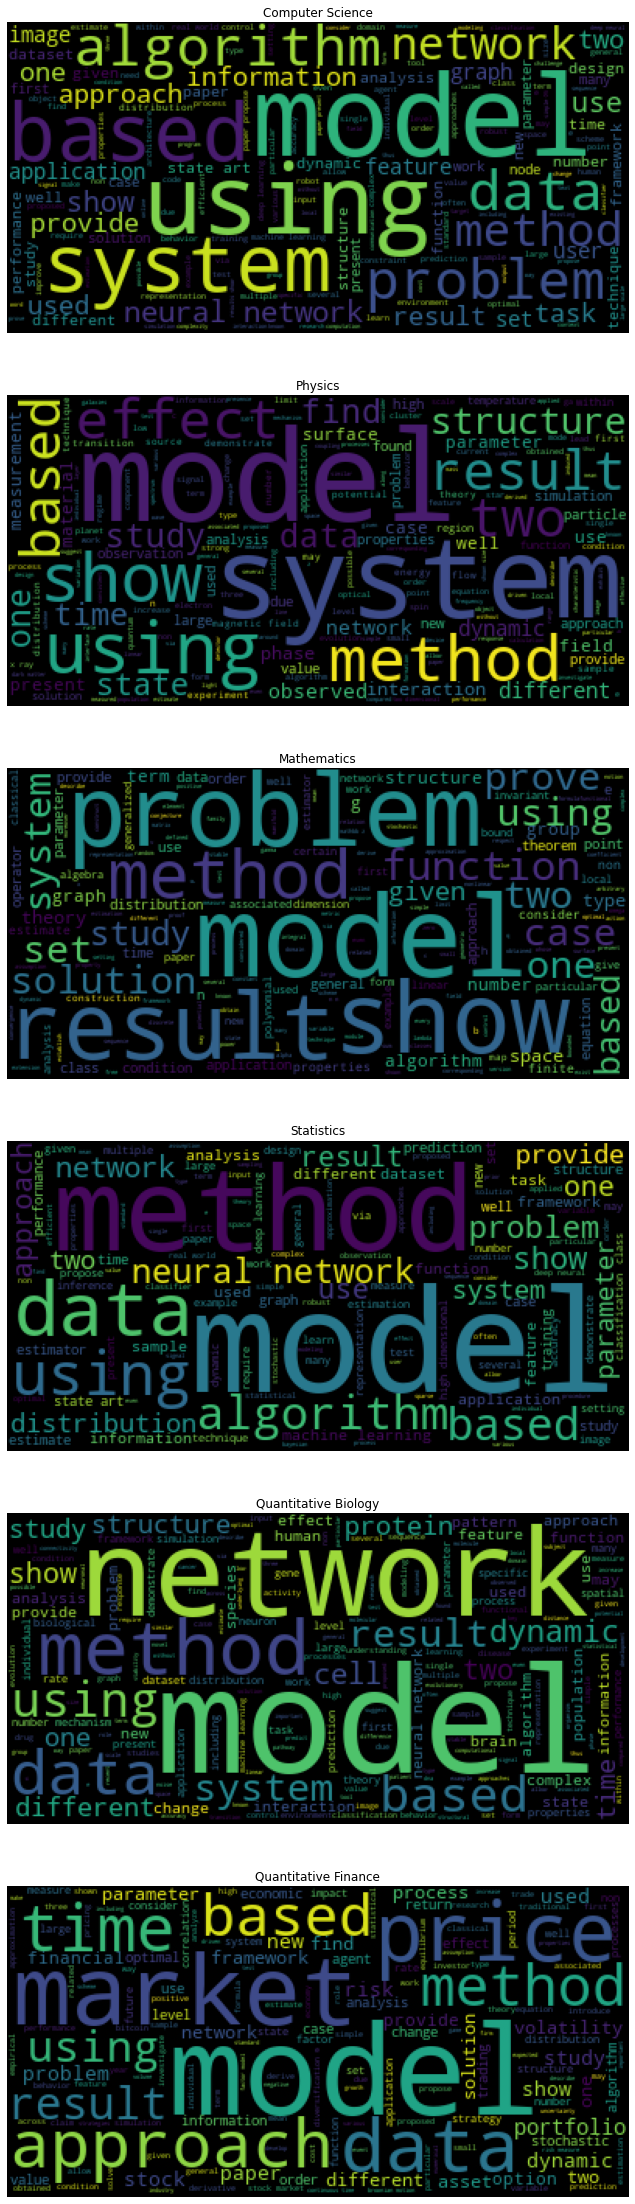

In [12]:
plt.figure(figsize=(40,40))

for i in range(len(subjects)):
    ax = plt.subplot(len(subjects), 1, i + 1)
    plt.imshow(WordCloud().generate(' '.join(subject_words[i])))
    plt.title(subjects[i])
    plt.axis("off")

# Data preprocessing continued...

In [13]:
df = pd.read_csv('cleaned.csv')
df

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Cleaned_text
0,1,0,0,0,0,0,reconstruct subject specif effect map predict ...
1,1,0,0,0,0,0,rotat invari neural network rotat invari trans...
2,0,0,1,0,0,0,spheric polyharmon poisson kernel polyharmon f...
3,0,0,1,0,0,0,finit element approxim stochast maxwel landau ...
4,1,0,0,1,0,0,compar studi discret wavelet transform wavelet...
...,...,...,...,...,...,...,...
20967,1,1,0,0,0,0,contemporari machin learn guid practition phys...
20968,0,1,0,0,0,0,uniform diamond coat wc co hard alloy cut inse...
20969,1,0,0,0,0,0,analys soccer game cluster conceptor present n...
20970,0,0,1,1,0,0,effici simul left tail sum correl log normal v...


In [14]:
# check for any null values 
df.count()

Computer Science        20972
Physics                 20972
Mathematics             20972
Statistics              20972
Quantitative Biology    20972
Quantitative Finance    20972
Cleaned_text            20972
dtype: int64

In [15]:
df = df.dropna()
 
df.count()

Computer Science        20972
Physics                 20972
Mathematics             20972
Statistics              20972
Quantitative Biology    20972
Quantitative Finance    20972
Cleaned_text            20972
dtype: int64

In [16]:
# Definfing output columns
 
y = np.array(df[subjects])

In [17]:
input = "Cleaned_text"
 
X = df[input]
X

0        reconstruct subject specif effect map predict ...
1        rotat invari neural network rotat invari trans...
2        spheric polyharmon poisson kernel polyharmon f...
3        finit element approxim stochast maxwel landau ...
4        compar studi discret wavelet transform wavelet...
                               ...                        
20967    contemporari machin learn guid practition phys...
20968    uniform diamond coat wc co hard alloy cut inse...
20969    analys soccer game cluster conceptor present n...
20970    effici simul left tail sum correl log normal v...
20971    option stop problem bayesian recent option sto...
Name: Cleaned_text, Length: 20972, dtype: object

In [18]:
split = int(0.8*len(df))
 
Xtrain, Xtest = X[:split], X[split:]
ytrain, ytest = y[:split], y[split:]
 
print("Train set - ", Xtrain.shape[0])
print("Test set - ", Xtest.shape[0])

Train set -  16777
Test set -  4195


In [19]:
# Tokenization
vocab = 15000
 
tokenizer = Tokenizer(num_words = vocab, oov_token = '<UNK>')
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
 
# Padding
mlen = 600
padding_type = 'post'
trunc_type = 'post'
 
Xtrain = tokenizer.texts_to_sequences(Xtrain)
Xtrain = pad_sequences(Xtrain, maxlen=mlen, padding=padding_type, truncating=trunc_type)
 
Xtest = tokenizer.texts_to_sequences(Xtest)
Xtest = pad_sequences(Xtest, maxlen=mlen, padding=padding_type, truncating=trunc_type)

# The model

In [20]:
# Build and train neural network
embedding_dim = 32
 
model = Sequential([
    Embedding(vocab, embedding_dim, input_length = mlen),
    GlobalAveragePooling1D(),
    Dense(32, activation = 'relu'),
    Dense(len(subjects), activation = 'sigmoid')
])
 
cb = [ModelCheckpoint('articles.h5', monitor = 'val_accuracy', save_best_only = True)]

In [21]:
model.compile(optimizer = Adam(0.1), loss = BinaryCrossentropy(), metrics = 'Accuracy')
 
history = model.fit(Xtrain, ytrain, batch_size=64, epochs = 256, validation_data=(Xtest, ytest), callbacks = cb)

Epoch 1/256
263/263 [==============================] - 2s 7ms/step - loss: 0.2507 - accuracy: 9.9342e-05 - val_loss: 0.1923 - val_accuracy: 1.9865e-04
Epoch 2/256
263/263 [==============================] - 2s 7ms/step - loss: 0.1671 - accuracy: 0.0022 - val_loss: 0.2186 - val_accuracy: 3.5757e-04
Epoch 3/256
263/263 [==============================] - 2s 7ms/step - loss: 0.1439 - accuracy: 0.0077 - val_loss: 0.2326 - val_accuracy: 0.0052
Epoch 4/256
263/263 [==============================] - 2s 7ms/step - loss: 0.1204 - accuracy: 0.0156 - val_loss: 0.2441 - val_accuracy: 0.0126
Epoch 5/256
263/263 [==============================] - 2s 7ms/step - loss: 0.1020 - accuracy: 0.0228 - val_loss: 0.2955 - val_accuracy: 0.0213
Epoch 6/256
263/263 [==============================] - 2s 7ms/step - loss: 0.0858 - accuracy: 0.0374 - val_loss: 0.3307 - val_accuracy: 0.0435
Epoch 7/256
263/263 [==============================] - 2s 7ms/step - loss: 0.0823 - accuracy: 0.0462 - val_loss: 0.3330 - val_accu

In [22]:
model.load_weights('articles.h5')

In [23]:
ypred = model.predict(Xtest)
ypred = (ypred>0.5).astype('int')
acc = accuracy_score(ytest, ypred)
f1 = f1_score(ytest,ypred, average='samples')

print("Accuracy = ", acc)
print("F1 score = ", f1)

Accuracy =  0.6126340882002383
F1 score =  0.7815971394517282


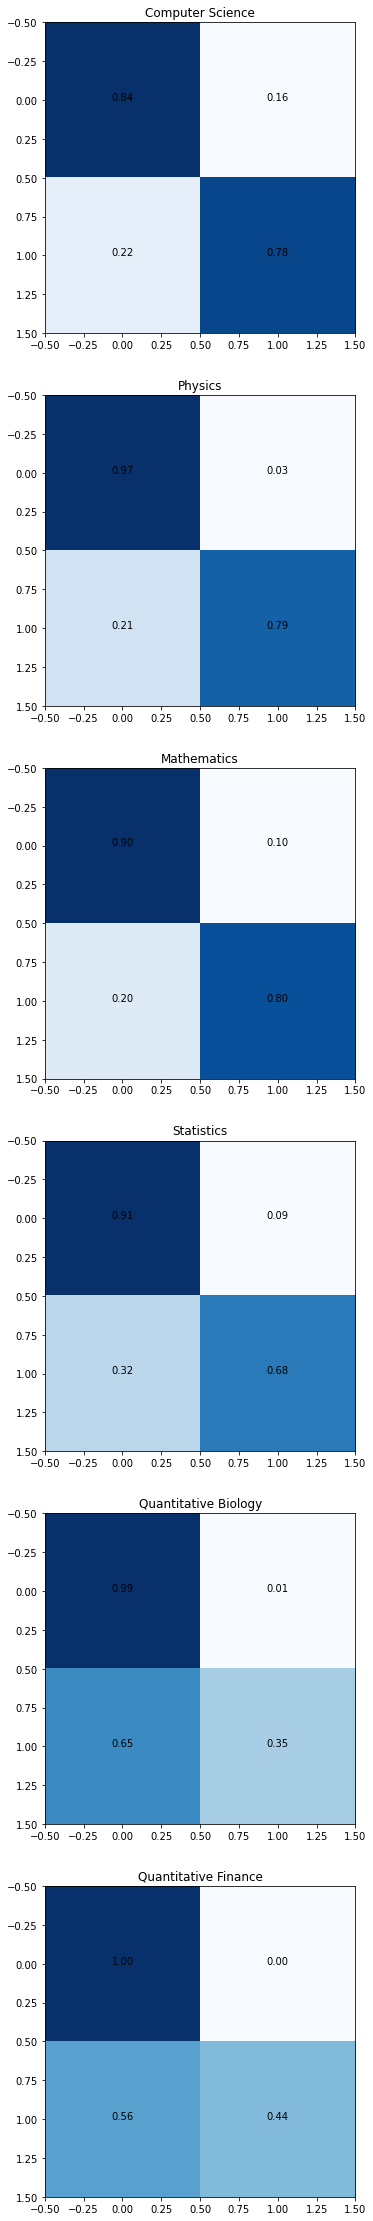

In [24]:
cm = multilabel_confusion_matrix(ytest, ypred)

plt.figure(figsize=(40,40))

for k in range(cm.shape[0]):
    cmi = cm[k].astype('float') / cm[k].sum(axis=1)[:, np.newaxis]

    ax = plt.subplot(len(subjects), 1, k+1)

    for i in range(cmi.shape[1]):
        for j in range(cmi.shape[0]):
            plt.text(j, i, format(cmi[i, j], '.2f'), horizontalalignment="center", color="black")

    plt.title(subjects[k])
    plt.imshow(cmi, cmap=plt.cm.Blues)

The low level of true positives for quantitaive biology and quantitative finanace is due to the low number of training samples.

# Plotting the metrics

In [25]:
def plot(history, variable, variable2):
    plt.plot(range(len(history[variable])), history[variable])
    plt.plot(range(len(history[variable2])), history[variable2])
    plt.legend([variable, variable2])
    plt.title(variable)

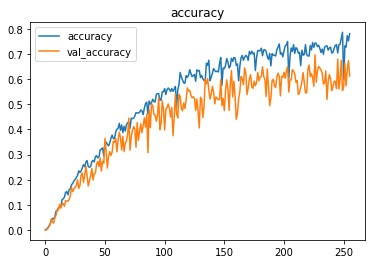

In [26]:
plot(history.history, "accuracy", 'val_accuracy')

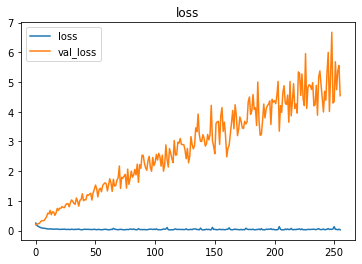

In [27]:
plot(history.history, "loss", 'val_loss')

# Prediction

In [28]:
df = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/researchArticles.csv')

In [29]:
x = np.random.randint(0, Xtest.shape[0] - 1)

title = df['TITLE'].values[x]
abstract = df['ABSTRACT'].values[x]

print("Title: ", title)
print("\nAbstract: ", abstract)

cleaned_text = []

title = removeURL(title) 
title = onlyAlphabets(title) 
title = title.lower()

abstract = removeURL(abstract) 
abstract = onlyAlphabets(abstract) 
abstract = abstract.lower()    

for word in title.split():
    if word not in stop:
        stemmed = sno.stem(word)
        cleaned_text.append(stemmed)

for word in abstract.split():
    if word not in stop:
        stemmed = sno.stem(word)
        cleaned_text.append(stemmed)  

cleaned_text = [' '.join(cleaned_text)]

print("Cleaned text: ", cleaned_text[0])

cleaned_text = tokenizer.texts_to_sequences(cleaned_text)
cleaned_text = pad_sequences(cleaned_text, maxlen=mlen, padding=padding_type, truncating=trunc_type)

s = df[subjects].values[x]  
s_num = np.where(s == 1)[0]

print("\nTrue subjects: ")
for si in s_num:
    print(subjects[si])

pred = model.predict(cleaned_text)[0]
predn = (pred>0.5).astype('int')
s_num = np.where(predn == 1)[0]

print("\nPredicted subjects: ")
for si in s_num:
    print(subjects[si], '(', pred[si], ')')

Title:  Stochastic Primal-Dual Method on Riemannian Manifolds with Bounded Sectional Curvature

Abstract:    We study a stochastic primal-dual method for constrained optimization over
Riemannian manifolds with bounded sectional curvature. We prove non-asymptotic
convergence to the optimal objective value. More precisely, for the class of
hyperbolic manifolds, we establish a convergence rate that is related to the
sectional curvature lower bound. To prove a convergence rate in terms of
sectional curvature for the elliptic manifolds, we leverage Toponogov's
comparison theorem. In addition, we provide convergence analysis for the
asymptotically elliptic manifolds, where the sectional curvature at each given
point on manifold is locally bounded from below by the distance function. We
demonstrate the performance of the primal-dual algorithm on the sphere for the
non-negative principle component analysis (PCA). In particular, under the
non-negativity constraint on the principle component and

# deepC

In [ ]:
!deepCC articles.h5